# Replies

## Data prep

### Load the data and count.

In [1]:
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import load_tweet_df, tweet_type

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Simply the tweet on load
def reply_transform(tweet):
    if tweet.get('in_reply_to_status_id'):
        return {
            'tweet_id': tweet['id_str'],
            'user_id': tweet['user']['id_str'],
            'screen_name': tweet['user']['screen_name'],
            'reply_to_user_id': tweet['in_reply_to_user_id_str'],
            'reply_to_screen_name': tweet['in_reply_to_screen_name'],
            'reply_to_tweet_id': tweet['in_reply_to_status_id_str'],
            'tweet_created_at': date_parse(tweet['created_at'])            
        }
    return None

reply_df = load_tweet_df(reply_transform, ['tweet_id', 'user_id', 'screen_name', 'reply_to_user_id',
                                           'reply_to_screen_name', 'reply_to_tweet_id', 'tweet_created_at'])


INFO:root:Loading from tweets/6eea2088e010437da4b6031c2abffdc9_001.json.gz
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
INFO:root:Loading from tweets/a7bcdbde7a104285b92fe26e286f2543_001.json.gz
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000
DEBUG:root:Loaded 500000
DEBUG:root:Loaded 550000
DEBUG:root:Loaded 600000
INFO:root:Loading from tweets/e1c824ff2b3c4c5a9a93a16e5036d09a_001.json.gz
DEBUG:root:Loaded 650000
DEBUG:root:Loaded 700000
DEBUG:root:Loaded 750000


### Number of replies found in the dataset

In [2]:
reply_df[['reply_to_user_id']].count()

reply_to_user_id    118570
dtype: int64

### The reply data

In [3]:
reply_df.head()

,tweet_id,user_id,screen_name,reply_to_user_id,reply_to_screen_name,reply_to_tweet_id,tweet_created_at
0,847428582821449730,780221130,loren_duggan,140286364,nielslesniewski,847424577009369094,2017-03-30 12:41:33+00:00
1,846472179902550017,29607664,adamliptak,106729916,espinsegall,846471674769936384,2017-03-27 21:21:09+00:00
2,846357290018099200,29607664,adamliptak,147586500,EdWhelanEPPC,846356576399212544,2017-03-27 13:44:37+00:00
3,847789885692018690,9484732,amacker,26117379,scottpllc,847046284297031681,2017-03-31 12:37:14+00:00
4,847486491727085568,9484732,amacker,9484732,amacker,847486211174219776,2017-03-30 16:31:39+00:00


### Create lookup of replied user ids to screen names

In [4]:
# From the replies, extract map of user ids to screen names
reply_to_user_id_lookup_df = reply_df.loc[reply_df.groupby('reply_to_user_id')['tweet_created_at'].idxmax()].ix[:,['reply_to_user_id', 'reply_to_screen_name']].set_index(['reply_to_user_id'])
reply_to_user_id_lookup_df.count()

reply_to_screen_name    27041
dtype: int64

In [5]:
reply_to_user_id_lookup_df.head()

,reply_to_screen_name
reply_to_user_id,
100005598,hotelkeys
10000772,JMoLawre
100025240,itsbull
100028531,Stevempars
100036032,Mitch_Tischler


### Create lookup of user ids to screen names

In [6]:
# From the users (not the mentions), extract map of user ids to screen names
user_id_lookup_df = reply_df.loc[reply_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    1510
dtype: int64

### Group replies by reply to user id

In [7]:
# Group by user_id
# This count should match the user_id map count
reply_to_summary_user_id_df = pd.DataFrame(reply_df.groupby('reply_to_user_id').size(), columns=['reply_to_count'])
reply_to_summary_user_id_df.count()

reply_to_count    27041
dtype: int64

In [8]:
reply_to_summary_user_id_df.head()

,reply_to_count
reply_to_user_id,
100005598,5
10000772,1
100025240,1
100028531,3
100036032,1


### Add back in the reply to screen names

In [9]:
# Join with user id map
reply_to_summary_screen_name_df = reply_to_summary_user_id_df.join(reply_to_user_id_lookup_df)
reply_to_summary_screen_name_df.count()

reply_to_count          27041
reply_to_screen_name    27041
dtype: int64

In [10]:
reply_to_summary_screen_name_df.head()

,reply_to_count,reply_to_screen_name
reply_to_user_id,,
100005598,5,hotelkeys
10000772,1,JMoLawre
100025240,1,itsbull
100028531,3,Stevempars
100036032,1,Mitch_Tischler


### Add users types for replies to

In [11]:
# Load lookups of known users
from utils import load_user_type_lookup_df

user_type_lookup_df = load_user_type_lookup_df()[['type']]
user_type_lookup_df.count()

type    13160
dtype: int64

In [12]:
user_type_lookup_df.head()

,type
user_id,
2345626885,journalists
780221130,journalists
285772181,journalists
29607664,journalists
9484732,journalists


In [13]:
user_type_lookup_df['type'].value_counts()

media                4538
journalists          3576
government           3055
politicians           817
ngo                   250
pundit                195
other                 160
other_political       156
cultural              131
academic              129
business              125
foreign_political      28
Name: type, dtype: int64

In [14]:
# Join the mentions and the known users
reply_to_summary_type_df = reply_to_summary_screen_name_df.join(user_type_lookup_df, how='left')
reply_to_summary_type_df['type'].fillna('unknown', inplace=True)
reply_to_summary_type_df.index.name = 'user_id'
reply_to_summary_type_df.count()

reply_to_count          27041
reply_to_screen_name    27041
type                    27041
dtype: int64

In [15]:
reply_to_summary_type_df.head()

,reply_to_count,reply_to_screen_name,type
user_id,,,
100005598,5,hotelkeys,unknown
10000772,1,JMoLawre,unknown
100025240,1,itsbull,unknown
100028531,3,Stevempars,unknown
100036032,1,Mitch_Tischler,unknown


### Add number of users replying to
Which is different than the number of replies to.

In [16]:
reply_to_user_id_per_user_df = reply_df[['reply_to_user_id', 'user_id']].drop_duplicates()
reply_to_user_id_per_user_summary_df = pd.DataFrame(reply_to_user_id_per_user_df.groupby('reply_to_user_id').size(), columns=['users_replying_to_count'])
reply_to_user_id_per_user_summary_df.index.name = 'user_id'
# Join with reply_to_summary_type_df
reply_to_summary_df = reply_to_summary_type_df.join(reply_to_user_id_per_user_summary_df)
reply_to_summary_df['percent_of_users_replying_to'] = reply_to_summary_df.users_replying_to_count / user_id_lookup_df['screen_name'].count()
reply_to_summary_df.head()


,reply_to_count,reply_to_screen_name,type,users_replying_to_count,percent_of_users_replying_to
user_id,,,,,
100005598,5,hotelkeys,unknown,3,0.001987
10000772,1,JMoLawre,unknown,1,0.000662
100025240,1,itsbull,unknown,1,0.000662
100028531,3,Stevempars,unknown,3,0.001987
100036032,1,Mitch_Tischler,unknown,1,0.000662


## Reply summary

### Replies per user
For users that made any replies. Also to possible to figure this out for all users.

In [17]:
reply_df['user_id'].value_counts().describe()

count    1510.000000
mean       78.523179
std       290.394805
min         1.000000
25%         3.000000
50%        13.000000
75%        57.000000
max      8009.000000
Name: user_id, dtype: float64

### How long is the tail?

In [18]:
replies_grouped_by_users_replying_to_df = reply_to_summary_df[['reply_to_count', 'users_replying_to_count']].groupby(by='users_replying_to_count').agg([np.sum, np.size])
replies_grouped_by_users_replying_to_df['cumulative_reply_to_count_sum'] = replies_grouped_by_users_replying_to_df['reply_to_count', 'sum'].cumsum()
replies_grouped_by_users_replying_to_df['cumulative_reply_to_count_sum_percentage'] = replies_grouped_by_users_replying_to_df['cumulative_reply_to_count_sum'] / replies_grouped_by_users_replying_to_df['reply_to_count', 'sum'].sum()
replies_grouped_by_users_replying_to_df['cumulative_replied_to_users'] = replies_grouped_by_users_replying_to_df['reply_to_count', 'size'].cumsum()
replies_grouped_by_users_replying_to_df['cumulative_replied_to_users_percentage'] = replies_grouped_by_users_replying_to_df['cumulative_replied_to_users'] / replies_grouped_by_users_replying_to_df['reply_to_count', 'size'].sum()
replies_grouped_by_users_replying_to_df

reply_to_count        cumulative_reply_to_count_sum  \
                                   sum   size                                 
users_replying_to_count                                                       
1                                36339  21420                         36339   
2                                11064   2616                         47403   
3                                 6909   1045                         54312   
4                                 4561    467                         58873   
5                                 4022    348                         62895   
6                                 3277    206                         66172   
7                                 3144    133                         69316   
8                                 2111    109                         71427   
9                                 2940     88                         74367   
10                                2926     81                         77293   
11                                1794     72                         79087   
12                                1990     58                         81077   
13                                 938     31                         82015   
14                                1214     37                         83229   
15                                1646     32                         84875   
16                                1433     25                         86308   
17                                1814     29                         88122   
18                                1312     26                         89434   
19                                1329     25                         90763   
20                                1299     19                         92062   
21                                1327     15                         93389   
22                                1716     19                         95105   
23                                 370      7                         95475   
24                                1513     11                         96988   
25                                 730      7                         97718   
26                                 478      8                         98196   
27                                1019      8                         99215   
28                                 797      6                        100012   
29                                1046     10                        101058   
30                                 157      3                        101215   
...                                ...    ...                           ...   
38                                 882      7                        106132   
39                                 569      3                        106701   
40                                 435      1                        107136   
41                                 243      1                        107379   
43                                 363      3                        107742   
44                                  72      1                        107814   
45                                 276      2                        108090   
46                                 119      1                        108209   
47                                 237      1                        108446   
48                                 281      2                        108727   
50                                2744      4                        111471   
51                                 371      3                        111842   
53                                 224      2                        112066   
54                                 121      1                        112187   
55                                 370      1                        112557   
56                                 150      1                        112707   
57                                 124      1                        11283

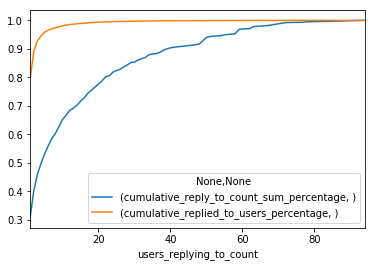

In [19]:
%matplotlib inline
replies_grouped_by_users_replying_to_df[['cumulative_reply_to_count_sum_percentage', 'cumulative_replied_to_users_percentage']].plot()

## Cut off the tail.
Removes users that were only replied to by 1 user.

In [20]:
reply_to_summary_df.drop(reply_to_summary_df[reply_to_summary_df.users_replying_to_count == 1].index, inplace=True)
reply_to_summary_df['reply_to_screen_name'].count()

5621

## Approach 1: By reply to count

### Top accounts (by reply to count)
Unknown for type indicates that it is not matched with an known Twitter account.

In [21]:
reply_to_summary_df.sort_values('reply_to_count', ascending=False).head(50)

,reply_to_count,reply_to_screen_name,type,users_replying_to_count,percent_of_users_replying_to
user_id,,,,,
22891564,2373,chrisgeidner,journalists,50,0.033113
3817401,1516,ericgeller,journalists,59,0.039073
118130765,881,dylanlscott,journalists,71,0.047020
46557945,848,StevenTDennis,journalists,63,0.041722
275207082,734,AlexParkerDC,journalists,24,0.015894
17466186,707,tomlobianco,journalists,17,0.011258
906734342,694,KimberlyRobinsn,journalists,7,0.004636
19847765,647,sahilkapur,journalists,34,0.022517
398088661,616,MEPFuller,journalists,94,0.062252


### Account types (by reply to count)

In [22]:
types_by_reply_to_count_df = reply_to_summary_df[['type', 'reply_to_count']].groupby('type').sum()
types_by_reply_to_count_df['type_percentage']= types_by_reply_to_count_df['reply_to_count'] / types_by_reply_to_count_df['reply_to_count'].sum()
types_by_reply_to_count_df.sort_values('reply_to_count', ascending=False)

,reply_to_count,type_percentage
type,,
journalists,59032,0.717880
unknown,12890,0.156754
pundit,3276,0.039839
other_political,1687,0.020515
other,1577,0.019178
academic,1195,0.014532
ngo,1131,0.013754
media,605,0.007357
politicians,333,0.004050


## Approach 2: Per user
Replies by type per user.

### Add type by merging screen name lookup

In [23]:
reply_all_join_df = pd.merge(reply_df, user_type_lookup_df[['type']], how='left', left_on='reply_to_user_id', right_index=True)
reply_all_join_df['type'].fillna('unknown', inplace=True)
# Drop tail
reply_all_join_df = reply_all_join_df[reply_all_join_df.reply_to_user_id.isin(reply_to_summary_df.index)]
reply_all_join_df.head()

,tweet_id,user_id,screen_name,reply_to_user_id,reply_to_screen_name,reply_to_tweet_id,tweet_created_at,type
0,847428582821449730,780221130,loren_duggan,140286364,nielslesniewski,847424577009369094,2017-03-30 12:41:33+00:00,journalists
1,846472179902550017,29607664,adamliptak,106729916,espinsegall,846471674769936384,2017-03-27 21:21:09+00:00,academic
2,846357290018099200,29607664,adamliptak,147586500,EdWhelanEPPC,846356576399212544,2017-03-27 13:44:37+00:00,academic
3,847789885692018690,9484732,amacker,26117379,scottpllc,847046284297031681,2017-03-31 12:37:14+00:00,unknown
4,847486491727085568,9484732,amacker,9484732,amacker,847486211174219776,2017-03-30 16:31:39+00:00,journalists


In [24]:
reply_summary_by_user_df = reply_all_join_df.groupby([reply_all_join_df.user_id, reply_all_join_df.type]).size().unstack().fillna(0)
# Add a total column
reply_summary_by_user_df['total'] = reply_summary_by_user_df.sum(axis=1)
for col_name in reply_summary_by_user_df.columns[:-1]:
    reply_summary_by_user_df['{}_percent'.format(col_name)] = reply_summary_by_user_df[col_name] / reply_summary_by_user_df.total
reply_summary_by_user_df.head(10)

type,academic,business,cultural,government,journalists,media,ngo,other,other_political,politicians,...,cultural_percent,government_percent,journalists_percent,media_percent,ngo_percent,other_percent,other_political_percent,politicians_percent,pundit_percent,unknown_percent
user_id,,,,,,,,,,,,,,,,,,,,,
100165378,0.0,0.0,13.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,...,0.52,0.000000,0.160000,0.0,0.000000,0.0,0.04,0.04,0.000000,0.240000
1001991865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,1.000000
1002229862,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.750000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.250000
100802089,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.333333,0.0,0.000000,0.0,0.00,0.00,0.000000,0.666667
100860790,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.500000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.500000
1009749229,2.0,0.0,0.0,2.0,73.0,0.0,4.0,0.0,0.0,0.0,...,0.00,0.024096,0.879518,0.0,0.048193,0.0,0.00,0.00,0.024096,0.000000
1013785220,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,1.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000
102171691,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.142857,0.714286,0.0,0.000000,0.0,0.00,0.00,0.000000,0.142857
102238997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.000000,0.500000,0.0,0.000000,0.5,0.00,0.00,0.000000,0.000000


### Average of percent of replies by type for each user
That is, for each user determine the percent of replies by type. Then take the average of each type.

Thus, this mention analysis is on a per-user basis, accounting for how prolific a tweeter a user is. (That is, users who tweet aren't weighed more heavily.)

In [25]:
reply_summary_by_user_df.filter(axis=1, regex="_percent$").mean()

type
academic_percent           0.018718
business_percent           0.007318
cultural_percent           0.004393
government_percent         0.004183
journalists_percent        0.620576
media_percent              0.023570
ngo_percent                0.016683
other_percent              0.010210
other_political_percent    0.019884
politicians_percent        0.006863
pundit_percent             0.019340
unknown_percent            0.248261
dtype: float64

## Approach 3: By count of users replying to
The number of users that replied to an account. Thus, each user counts as 1, even if that user made multiple replies to the account.

This weights an account that is replied to a 100 users more heavily than an account that is replied to a 100 times by a single user.

In [26]:
reply_to_summary_df.sort_values('users_replying_to_count', ascending=False).head(20)

,reply_to_count,reply_to_screen_name,type,users_replying_to_count,percent_of_users_replying_to
user_id,,,,,
398088661,616,MEPFuller,journalists,94,0.062252
48120914,186,SopanDeb,journalists,78,0.051656
93069110,147,maggieNYT,journalists,76,0.050331
19186003,230,seungminkim,journalists,72,0.047682
118130765,881,dylanlscott,journalists,71,0.047020
13524182,116,daveweigel,journalists,71,0.047020
16244449,212,jbarro,journalists,67,0.044371
14412533,113,CillizzaCNN,journalists,65,0.043046
19107878,115,GlennThrush,journalists,64,0.042384


### Account types (by count of users replying to)

In [27]:
types_by_users_replying_to_df = reply_to_summary_df[['type', 'users_replying_to_count']].groupby('type').sum()
types_by_users_replying_to_df['type_percentage']= types_by_users_replying_to_df['users_replying_to_count'] / types_by_users_replying_to_df['users_replying_to_count'].sum()
types_by_users_replying_to_df.sort_values('users_replying_to_count', ascending=False)

,users_replying_to_count,type_percentage
type,,
journalists,15913,0.575682
unknown,7644,0.276536
pundit,998,0.036104
other_political,883,0.031944
academic,510,0.018450
media,453,0.016388
ngo,451,0.016316
other,301,0.010889
politicians,203,0.007344


## Unknown accounts
Remember, the tail has been cut off

### Number of unknown accounts

In [28]:
 reply_to_summary_df[reply_to_summary_df.type == 'unknown'].count()

reply_to_count                  3120
reply_to_screen_name            3120
type                            3120
users_replying_to_count         3120
percent_of_users_replying_to    3120
dtype: int64

### Number of known accounts

In [29]:
 reply_to_summary_df[reply_to_summary_df.type != 'unknown'].count()

reply_to_count                  2501
reply_to_screen_name            2501
type                            2501
users_replying_to_count         2501
percent_of_users_replying_to    2501
dtype: int64

### Top unknown by reploy to count that are replied to by at least 5 users

In [30]:
top_not_known_reply_to_df = reply_to_summary_df[(reply_to_summary_df.type == 'unknown') & (reply_to_summary_df.users_replying_to_count >= 5)].sort_values('reply_to_count', ascending=False)[['reply_to_screen_name', 'reply_to_count', 'users_replying_to_count']]
top_not_known_reply_to_df.head(50)

,reply_to_screen_name,reply_to_count,users_replying_to_count
user_id,,,
1173121356,xenocryptsite,17,5
18111042,michaelpfreeman,11,5
39100192,Southfive,11,5
415794979,AndStrats,10,5
166207886,BrianLaslie,10,5
4440118883,luke_j_obrien,10,6
48585729,cam_mason,10,6
14372270,mcbyrne,9,5
338164741,bsdtectr,9,5


### Write top accounts to file

In [31]:
top_not_known_reply_to_df.to_csv('unknown_replies.csv')